# ETL Assigment<br>
![etl](https://www.pngitem.com/pimgs/m/537-5379917_extract-transform-load-logo-hd-png-download.png)
<br>
### Problem Defination
In this assigment, Data need to be loaded from source. Transformed in such a fashion that output should be a database supported (sql) file. Transformation that need be done is adding an extra column which will contain date and time.<br>
### Points that need to be covered
* **When loading files, only specific files need to be loaded.**
* **New field should be added to existing data which will contain Date and timestamp.**
* **Output should be a sql file/dump.**

## ETL Process
### by Abhishek Padghane as follows:

* Getting some random files and storing it in data folder.
* Getting files which consist data for ETL and renaming them according to problem statement.
* Loading the files as pandas Dataframe.
* Performing required analysis.
* Saving files in database (sql format).

## Third party libraries
![pandas](https://upload.wikimedia.org/wikipedia/commons/thumb/e/ed/Pandas_logo.svg/1200px-Pandas_logo.svg.png)
![sqlalchemy](https://hakin9.org/wp-content/uploads/2019/08/connect-a-flask-app-to-a-mysql-database-with-sqlalchemy-and-pymysql.jpg)
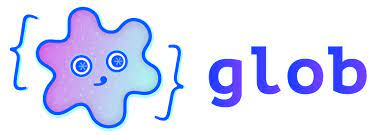
![dotenv](https://raw.githubusercontent.com/motdotla/dotenv/master/dotenv.png)

In [ ]:
# importing required libraries

# re for regular expression
import re

# os for system related operations
import os

# glob for extracting required files
import glob

# dotenv to read credentials as environmental variables
import dotenv

# pandas for data processing
import pandas

# warnings for handle warning
import warnings

# datetime for date and time related operations
import datetime

# sqlalchemy for connection with mariadb DBMS application
import sqlalchemy

# hiding all warnings
warnings.filterwarnings('ignore')

![etl](https://www.astera.com/wp-content/uploads/2019/10/etl.png)

## EXTRACT
In this process, i am extracting my data from **.csv**(comma separated value) format.<br>
Rules are:
* File name should be like "Analytics_dd_mm_yyyy"
* File format should be csv<br>
using `glob.glob`(*regex*) for getting file name based on search pattern

In [ ]:
# initializing data directory
data_directory = "Analytics"

# initializing date pattern regex
date_pattern = r"[0-9][0-9]-[0-9][0-9]-[0-9][0-9][0-9][0-9]"

# initializing regex for searching files
file_search_pattern = data_directory + "_" + date_pattern

# initializing file format, in our case its csv
file_format = ".csv"

# getting files with path associated
data_files = glob.glob(os.path.join(data_directory, file_search_pattern + file_format))

# displaying files
print("Files are:\n")
for files in data_files:
    print(files[len(data_directory)+1:])

Using `pandas.read_csv`(*file path*) for reading data into `pandas.DataFrame()` API.<br>
Storing all files Dataframes into a `List`

In [ ]:
# reading data of files, using pandas DataFrame API / Data structure for our data
data_files_df_list = list(map(pandas.read_csv, data_files))

Analyzing **schema** of one of the df, considered all df schema are similar.

In [ ]:
# displaying schema
print("Fields are:\n")
for column in data_files_df_list[0].columns:
    print(column)

In [ ]:
# Analyzing file by looking first 5 values of one of the file
data_files_df_list[0].head()

Analyzing columns of all df where sum of null values is greater than 0

In [ ]:
# analyzing which columns have null values greater than 0

print("Checking columns with null values:\n\n")
for files, df in zip(data_files, data_files_df_list):
    print(f"Columns with higher null total then other columns in {files[len(data_directory)+1:]}:\n")
    display_list = []
    
    # adding fields and nul value total which is higher than 0 in a list
    for field, null_val in zip(df.columns, df.isnull().sum()):
        if null_val > 0:
            display_list.append([field, str(null_val)])
    
    # printing field and nul value total
    for display in display_list:
        for entry in display:
            print(entry.ljust(25), end='')
        print()
    print("\n")

## TRANSFORM
Now as we can see, **Trades, Deliverable Volume, %Deliverble** have high number of null value sum, removing them. Using `pandas.DataFrame.drop`(*columns, inplace=False, axis=0* )

In [ ]:
# removing fields that consists higher nulls
higher_null_columns = ["Trades", "Deliverable Volume", "%Deliverble"]

for df in data_files_df_list:
    df.drop(columns=higher_null_columns, inplace=True, axis=1)

In [ ]:
# Analyzing file by looking first 5 values after removal of above columns
data_files_df_list[0].head()

Assigning a new column **File_Date_Time** for storing datetime of csv files.

In [ ]:
# initializing datetime format
date_time_format = "%d-%m-%Y"

# making a new column which consist the datetime of file
for files, df in zip(data_files, data_files_df_list):
    df["File_Date_Time"] = datetime.datetime.strptime(re.search(date_pattern, files).group(), date_time_format)

In [ ]:
# Analyzing file by looking first 5 values after transformation
data_files_df_list[1].head()

In [ ]:
# checking data types of columns
data_files_df_list[0].dtypes

## LOAD
Making connection to mariadb dbms. First loading db credentials as environment variable using `dotenv.load_dotenv()` then `sqlalchemy.create_engine()` for db connection.

In [ ]:
# loading db credentials as environment variables
dotenv.load_dotenv()

# making a db connection
database_connection = sqlalchemy.create_engine(f'mysql+mysqlconnector://{os.environ["USER"]}:{os.environ["PASS"]}@'
                           f'{os.environ["HOST"]}:{os.environ["PORT"]}/{os.environ["NAME"]}')

Writing df into db tables using `pandas.DataFrame.to_sql()`

In [ ]:
# saving/writing df to sql tables
for df_pos, file_name in zip(range(len(data_files_df_list)), data_files):
    
    # initializing table name
    table_name = "_".join(file_name[len(data_directory)+1:-4].split("-"))
    
    # writing data in sql table
    data_files_df_list[df_pos].to_sql(con=database_connection, name=table_name, if_exists='replace')